# Импорт модулей

In [ ]:
# Подавление предупреждений
import warnings
for warn in [UserWarning, FutureWarning]: warnings.filterwarnings("ignore", category = warn)

# Импорт необходимых библиотек
import os
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import polars as pl
import pandas as pd
import yfinance as yf
import sklearn
import networkx as nx
# import jupyterlab as jlab
# import ipywidgets
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader

from sklearn.preprocessing import MinMaxScaler
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from tqdm import tqdm

from scipy import stats

In [ ]:
# Версии необходимых библиотек
packages = [
    "Torch", "NumPy", "Polars", "Pandas", "Matplotlib", "Yfinance", "Scikit-learn", "NetworkX"
]

package_objects = [
    torch, np, pl, pd, mpl, yf, sklearn, nx
]

versions = list(map(lambda obj: obj.__version__, package_objects))

columns_order = ["№", "Библиотека", "Версия"]
df_pkgs = (
    pl.DataFrame({
        columns_order[1]: packages,
        columns_order[2]: versions
    })
    .with_columns(pl.arange(1, pl.lit(len(packages)) + 1).alias(columns_order[0]))
    .select(columns_order)
)

display(df_pkgs)

path2reqs = "."
reqs_name = "requirements.txt"

def get_packages_and_versions():
    """Генерация строк с библиотеками и их версиями в формате: библиотека==версия"""

    for package, version in zip(packages, versions):
        yield f"{package.lower()}=={version}\n"

with open(os.path.join(path2reqs, reqs_name), "w", encoding = "utf-8") as f:
    f.writelines(get_packages_and_versions())

№,Библиотека,Версия
i64,str,str
1,"""Torch""","""2.8.0+cu126"""
2,"""NumPy""","""2.0.2"""
3,"""Polars""","""1.25.2"""
4,"""Pandas""","""2.2.2"""
5,"""Matplotlib""","""3.10.0"""
6,"""Yfinance""","""0.2.66"""
7,"""Scikit-learn""","""1.6.1"""
8,"""NetworkX""","""3.5"""


In [ ]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE

device(type='cuda')

In [ ]:
SEED = 42
BATCH_SIZE = 16

# Загрузка данных

In [ ]:
ticker = "BTC-USD"
data = yf.download(ticker, start = "2020-01-01", end = pd.Timestamp.now().strftime('%Y-%m-%d'))
data = data[['Close']]
pd.concat((data.head(2), data.tail(3)), axis=0)

[*********************100%***********************]  1 of 1 completed


Price,Close
Ticker,BTC-USD
Date,
2020-01-01,7200.174316
2020-01-02,6985.470215
2025-10-28,112956.164062
2025-10-29,110055.304688
2025-10-30,108305.546875


# Нормализация данных

In [ ]:
ecdf = stats.ecdf(data[('Close', 'BTC-USD')])

def inverse_ecdf(data):
    x = ecdf.cdf.quantiles

    return np.quantile(x, data, method='lower')

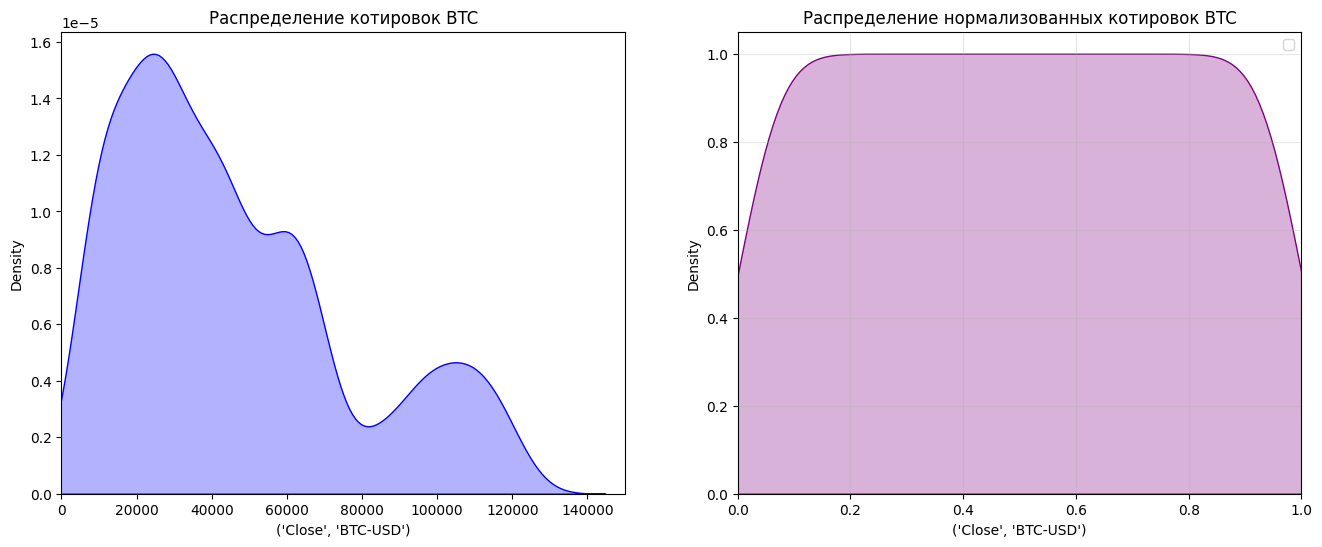

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# sns.set_palette("husl")

sns.kdeplot(data[('Close', 'BTC-USD')], fill=True, alpha=0.3, linewidth=1, color='blue', ax = axes[0])
axes[0].set_xlim(0, 150000)
axes[0].set_title('Распределение котировок BTC')

sns.kdeplot(data[('Close', 'BTC-USD')].apply(ecdf.cdf.evaluate), fill=True, alpha=0.3, linewidth=1, color='purple', ax=axes[1])
axes[1].set_xlim(0, 1)
axes[1].set_title('Распределение нормализованных котировок BTC')

# plt.title('Нормализация', fontsize=16, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show();

In [ ]:
data[('Close', 'BTC-USD')] = data[('Close', 'BTC-USD')].apply(ecdf.cdf.evaluate)

data = data.to_numpy()
data, data.shape

(array([[0.01877934],
        [0.01596244],
        [0.02112676],
        ...,
        [0.9657277 ],
        [0.95211268],
        [0.94319249]]),
 (2130, 1))

Здесь я использовал следующий факт: если $F(x)$ -- функция случайной величины $\xi$, то $F(\xi) \sim Uniform[0, 1]$ (преобразование Смирнова).
Альтернатива обычного MinMaxScaler'a, при котором не будет скошенности распределения (а в исходных данных она есть)

# Разделение данных на train и test

In [ ]:
def create_sequences(data, seq_length):
    X_train, X_test = [], []
    y_train, y_test = [], []

    i = 0
    while i < len(data) - seq_length:
        if 50 <= i % 100 < 70:
            X_test.append(data[i:i+seq_length])
            y_test.append(data[i+seq_length])
            i += 1
            continue

        if i % 100 == 60:
            i += seq_length
            continue

        X_train.append(data[i:i+seq_length])
        y_train.append(data[i+seq_length])

        i += 1

    return torch.FloatTensor(X_train), torch.FloatTensor(X_test), torch.FloatTensor(y_train), torch.FloatTensor(y_test)

seq_length = 60 # TODO: change
X_train, X_test, y_train, y_test = create_sequences(data, seq_length)

train = [
    {"prices" : prices, "price_last" : price_last} for prices, price_last in zip(X_train, y_train)
]

test = [
    {"prices" : prices, "price_last" : price_last} for prices, price_last in zip(X_test, y_test)
]

pd.DataFrame({
    'Train Size' : [len(train)],
    'Test Size' : [len(test)]
})

,Train Size,Test Size
0,1650,420


Здесь я разделил данные так, чтобы отрезки test и train чередовались на временной прямой. Эвристика такая: если данные разделены равномерно, то вероятность нахождения в test паттерна, не встречающегося в train меньше, чем если бы разделение производилось одной границей

In [ ]:
gen = torch.Generator()
gen.manual_seed(SEED)

# Функция для загрузчика
def collate_batch(batch):
    prices     = list(map(lambda item: item["prices"].to(DEVICE), batch))
    price_last = list(map(lambda item: item["price_last"].to(DEVICE), batch))
    price_last = torch.FloatTensor(price_last).to(DEVICE)

    prices = pad_sequence(prices, batch_first = True)

    return prices, price_last

train_dataloader = DataLoader(
    train, batch_size = BATCH_SIZE, generator = gen, shuffle = True, drop_last = False, collate_fn = collate_batch
)
test_dataloader = DataLoader(
    test, batch_size = BATCH_SIZE, generator = gen, shuffle = True, drop_last = False, collate_fn = collate_batch
)

# Создание модели

In [ ]:
class GRU(nn.Module):
    def __init__(self, input_size = 1, hidden_size = 128, num_layers = 2):
        super(GRU, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.gru = nn.GRU(
            input_size = input_size,
            hidden_size = hidden_size,
            num_layers = num_layers,
            dropout = 0.3,
            batch_first = True
        )
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).requires_grad_().to(DEVICE)
        out, hn = self.gru(x, h0.detach())
        out = self.fc(out[:, -1, :])
        return out

def RMSELoss(yhat,y):
    return torch.sqrt(torch.mean((yhat-y)**2))

model = GRU().to(DEVICE)
criterion = RMSELoss
optimizer = optim.Adam(model.parameters(), lr = 0.001)

# Обучение модели

In [ ]:
def fit_model(model, criterion, optimizer, num_epochs=10_000):

    train_loss = []
    grad_norms = []

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        total_grad_norm = 0

        for i, batch in enumerate(train_dataloader):
            inputs = batch[0]
            target = batch[1]

            optimizer.zero_grad()
            output = model(inputs)
            loss = criterion(output, target)
            loss.backward()

            grad_norm = 0
            for p in model.parameters():
                if p.grad is not None:
                    param_norm = p.grad.data.norm(2)
                    grad_norm += param_norm.item() ** 2
            grad_norm = grad_norm ** 0.5

            optimizer.step()

            total_loss += loss.item()
            total_grad_norm += grad_norm

        avg_loss = total_loss / len(train_dataloader)
        train_loss.append(avg_loss)

        avg_grad_norm = total_grad_norm / len(train_dataloader)
        grad_norms.append(avg_grad_norm)

        if epoch % 100 == 0:
            print(f'---------- Epoch {epoch}, Loss: {avg_loss:.6f}, Grad_Norm: {avg_grad_norm:.6f} ----------')

    return train_loss, grad_norms

train_loss, grad_norms = fit_model(model, criterion, optimizer)

# Инфографика по модели

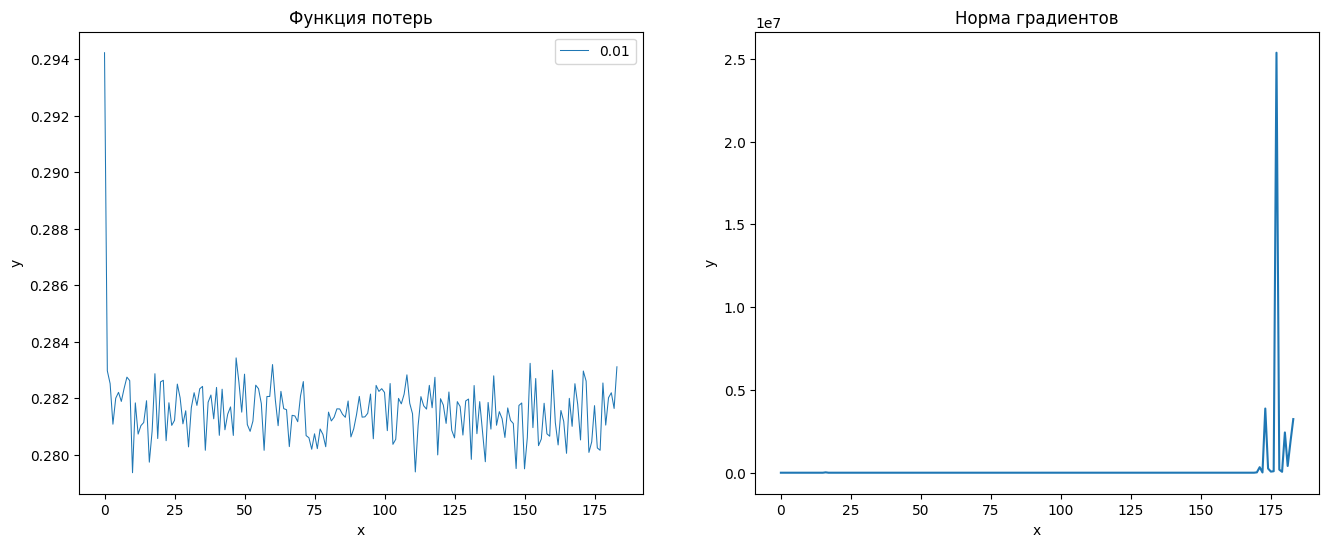

<Figure size 640x480 with 0 Axes>

In [ ]:
data_1 = pd.DataFrame({'x' : np.arange(len(train_loss[::100])), 'y' : train_loss[::100]})
data_2 = pd.DataFrame({'x' : np.arange(len(grad_norms[::100])), 'y' : grad_norms[::100]})

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.lineplot(data_1, x='x', y='y', ax=axes[0], size=0.01, linewidth=0.0001)
axes[0].set_title("Функция потерь")

sns.lineplot(data_2, x='x', y='y', ax=axes[1])
axes[1].set_title("Норма градиентов")

plt.show()
plt.tight_layout();

*Налицо проблема затухающих и взрывающихся градиентов. Попробуем добавить gradient clipping и уменьшить learning rate.*

# Исправляем ошибки

In [ ]:
model = GRU().to(DEVICE)
criterion = RMSELoss
optimizer = optim.Adam(model.parameters(), lr = 0.0001)

torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

train_loss, grad_norms = fit_model(model, criterion, optimizer)

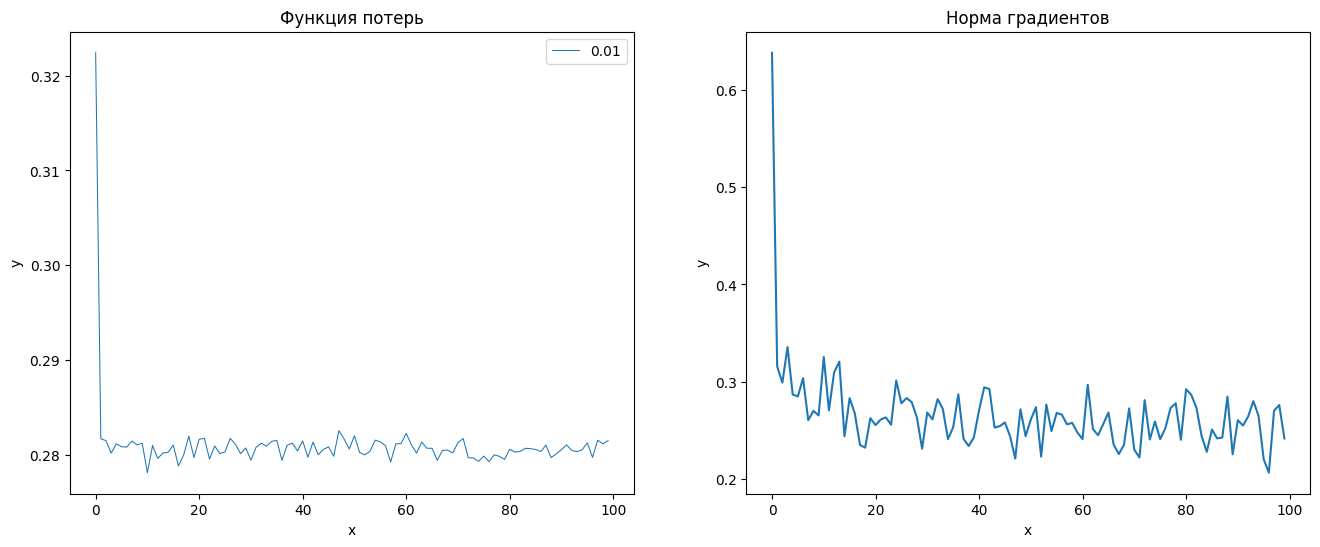

<Figure size 640x480 with 0 Axes>

In [ ]:
data_1 = pd.DataFrame({'x' : np.arange(len(train_loss[::100])), 'y' : train_loss[::100]})
data_2 = pd.DataFrame({'x' : np.arange(len(grad_norms[::100])), 'y' : grad_norms[::100]})

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.lineplot(data_1, x='x', y='y', ax=axes[0], size=0.01, linewidth=0.0001)
axes[0].set_title("Функция потерь")

sns.lineplot(data_2, x='x', y='y', ax=axes[1])
axes[1].set_title("Норма градиентов")

plt.show()
plt.tight_layout();

*Промежуточный прогресс: градиенты не взрываются и не затухают (по графику видно, что снижаются достаточно адекватно). Попробуем изменить стратегию градиентного спуска*

## Подключаем `AdamW`

In [ ]:
model = GRU().to(DEVICE)
criterion = RMSELoss
optimizer = optim.AdamW(
    model.parameters(),
    lr=0.001,
    weight_decay=0.01,
    betas=(0.9, 0.999)
)

torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

train_loss, grad_norms = fit_model(model, criterion, optimizer)

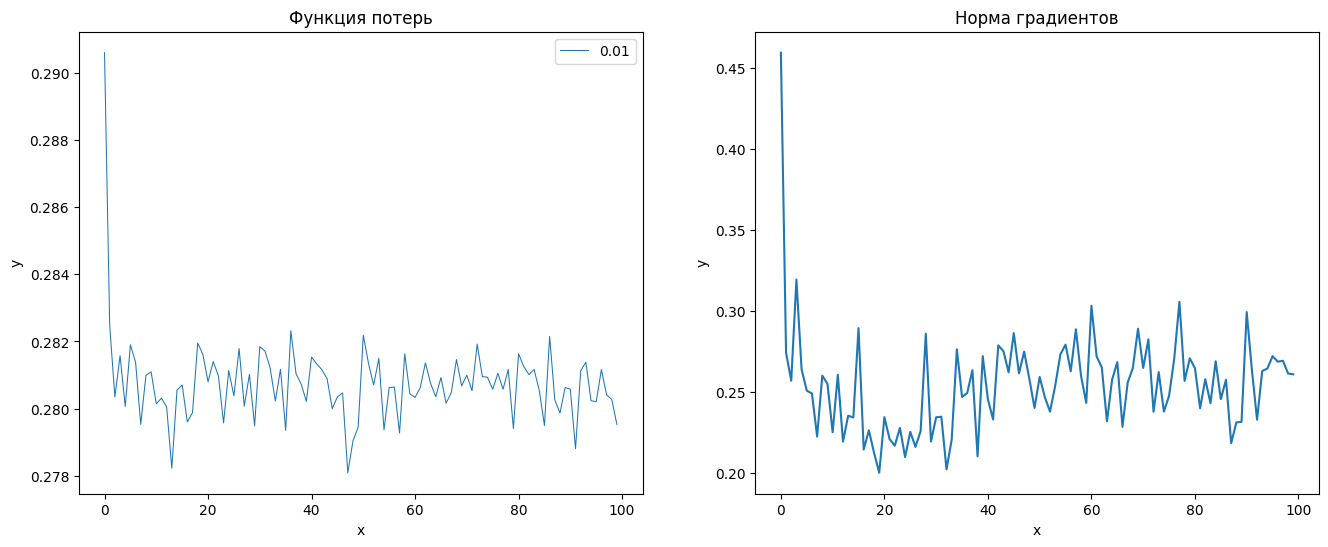

<Figure size 640x480 with 0 Axes>

In [ ]:
data_1 = pd.DataFrame({'x' : np.arange(len(train_loss[::100])), 'y' : train_loss[::100]})
data_2 = pd.DataFrame({'x' : np.arange(len(grad_norms[::100])), 'y' : grad_norms[::100]})

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.lineplot(data_1, x='x', y='y', ax=axes[0], size=0.01, linewidth=0.0001)
axes[0].set_title("Функция потерь")

sns.lineplot(data_2, x='x', y='y', ax=axes[1])
axes[1].set_title("Норма градиентов")

plt.show()
plt.tight_layout();

Почти ничего не изменилось

# Качество модели на тестовой выборке

In [ ]:
model.eval();

In [ ]:
def forecast(model, sequence, days = 30):
    current_seq = sequence.squeeze(0)
    predictions = []
    for _ in range(days):
        pred = model(current_seq.unsqueeze(0))
        predictions.append(pred.item())
        current_seq = torch.cat((current_seq[1:], pred))
    return predictions

last_sequence = X_train[-1]
input_tensor = torch.FloatTensor(last_sequence).unsqueeze(0).to(DEVICE)
normalized_forecast = forecast(model, input_tensor, days = 30)
forecast_prices = inverse_ecdf(np.array(normalized_forecast).reshape(-1, 1))

In [ ]:
# Преобразование предсказаний и тестовых данных
model.eval()
test_predictions = []
with torch.no_grad():
    for seq in X_test:
        pred = model(seq.unsqueeze(0).to(DEVICE))
        test_predictions.append(pred.item())

test_predictions = inverse_ecdf(np.array(test_predictions).reshape(-1, 1))
y_test_original = inverse_ecdf(y_test.numpy().reshape(-1, 1))

In [ ]:
pd.DataFrame({
    "y_pred" : test_predictions.flatten(),
    "y_true" : y_test_original.flatten()
})

,y_pred,y_true
0,37289.621094,6881.958496
1,37289.621094,6880.323242
2,37289.621094,7117.207520
3,37289.621094,7429.724609
4,37289.621094,7550.900879
...,...,...
415,41733.941406,114472.445312
416,41733.941406,114119.328125
417,41733.941406,112956.164062
418,41733.941406,110055.304688


In [ ]:
RMSELoss(torch.FloatTensor(test_predictions.flatten()), torch.FloatTensor(y_test_original.flatten())).item()

30762.97265625

# Итоги

*Ничего не получилось. Предположительно причина в высокой волатильности котировок и их сущещственной зависимости от внешних факторов, которые не учитывает модель*